In [ ]:
print("Init")

Init


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import DataCollatorWithPadding
import time

# IndoBERT

In [ ]:
PATH = "clean_df.csv"
dataset = pd.read_csv(PATH)
dataset.head()

,Customer Review,Sentiment,Emotion
0,alhamdulillah berfungsi dengan baik packaging ...,1,0
1,barang bagus dan respon cepat harga bersaing d...,1,0
2,barang bagus berfungsi dengan baik seler ramah...,1,0
3,bagus sesuai harapan penjual nya juga ramah tr...,1,0
4,barang bagus pengemasan aman dapat berfungsi d...,1,0


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

def tokenize_function(review):
    return tokenizer(review["Customer Review"], padding="max_length", truncation=True, max_length=64)

data = Dataset.from_pandas(dataset)
data = data.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/5300 [00:00<?, ? examples/s]

In [ ]:
for review in dataset["Customer Review"][:5]:
    print(tokenizer.tokenize(review))

['alhamdulillah', 'berfungsi', 'dengan', 'baik', 'pack', '##aging', 'aman', 'respon', 'cepat', 'dan', 'ramah', 'sel', '##ler', 'dan', 'kurir', 'amanah']
['barang', 'bagus', 'dan', 'respon', 'cepat', 'harga', 'bersaing', 'dengan', 'yg', 'lain']
['barang', 'bagus', 'berfungsi', 'dengan', 'baik', 'sel', '##er', 'ramah', 'pengiriman', 'cepat']
['bagus', 'sesuai', 'harapan', 'penjual', 'nya', 'juga', 'ramah', 'trim', '##akas', '##ih', 'pelap', '##ak']
['barang', 'bagus', 'pengem', '##asan', 'aman', 'dapat', 'berfungsi', 'dengan', 'baik']


In [ ]:
encoding = tokenizer(review, padding="max_length", truncation=True, max_length=32)
print("Input IDs:", encoding["input_ids"])
print("Attention Mask:", encoding["attention_mask"])
print("Token Type IDs:", encoding["token_type_ids"])

Input IDs: [3, 2855, 4839, 8741, 1720, 4022, 1708, 5671, 1545, 1983, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Data Partition

In [ ]:
train_test_split = data.train_test_split(test_size=0.2, seed=42) # 80:20
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [ ]:
train_dataset

Dataset({
    features: ['Customer Review', 'Sentiment', 'Emotion', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4240
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Fine-Tune IndoBERT

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred #logits = nilai hasil mentah dari model, labels = label
    predictions = np.argmax(logits, axis=1) # nilai max dari logits/baris
    accuracy = accuracy_score(labels, predictions) # penghitungan akurasi
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

### Sentiment Model


In [ ]:
# # Hyperparameters
# learning_rates = [2e-5, 3e-5, 5e-5]
# batch_sizes = [8, 16]
# weight_decays = [0.0, 0.01]
# epoch = 5

# results_list = []
# best_accuracy = 0
# best_config = {}
# total_time = 0
# model_sentiment = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=2)

# # Loop
# for lr in learning_rates:
#     for bs in batch_sizes:
#         for wd in weight_decays:
#             print(f"\n🔄 Training with lr={lr}, batch_size={bs}, weight_decay={wd}")
#             start_time = time.time()

#             training_args_sentiment = TrainingArguments(
#                 output_dir=f"./sentiment_results/lr{lr}_bs{bs}_wd{wd}",
#                 eval_strategy="epoch",
#                 save_strategy="epoch",
#                 logging_dir="./logs",
#                 learning_rate=lr,
#                 per_device_train_batch_size=bs,
#                 per_device_eval_batch_size=bs,
#                 num_train_epochs=epoch,
#                 weight_decay=wd,
#                 save_total_limit=2,
#                 load_best_model_at_end=True,
#                 report_to="none"
#             )

#             trainer = Trainer(
#                 model=model_sentiment,
#                 args=training_args_sentiment,
#                 train_dataset=train_dataset.rename_column("Sentiment", "labels"),  # rename kolom sentimen -> labels
#                 eval_dataset=test_dataset.rename_column("Sentiment", "labels"),
#                 tokenizer=tokenizer,
#                 compute_metrics=compute_metrics
#             )

#             trainer.train()
#             eval_result = trainer.evaluate()
#             elapsed = time.time() - start_time

#             acc = eval_result["eval_accuracy"]
#             total_time += elapsed

#             results_list.append({
#                 "lr": lr,
#                 "batch_size": bs,
#                 "weight_decay": wd,
#                 "accuracy": acc,
#                 "time": elapsed
#             })

#             if acc > best_accuracy:
#                 best_accuracy = acc
#                 best_config = {
#                     "lr": lr,
#                     "batch_size": bs,
#                     "weight_decay": wd,
#                     "accuracy": acc,
#                     "time": elapsed
#                 }
# avg_time = total_time / len(results_list)
# avg_accuracy = np.mean([r["accuracy"] for r in results_list])

# print("\n✅ === BEST CONFIGURATION ===")
# print(f"Best Accuracy: {best_config['accuracy']:.4f}")
# print(f"Learning Rate: {best_config['lr']}")
# print(f"Batch Size: {best_config['batch_size']}")
# print(f"Weight Decay: {best_config['weight_decay']}")
# print(f"Training Time: {best_config['time']:.2f} seconds")

# print("\n📊 === AVERAGE RESULTS ===")
# print(f"Average Accuracy: {avg_accuracy:.4f}")
# print(f"Average Training Time: {avg_time:.2f} seconds per config")

In [ ]:
model_sentiment = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=2)
training_args_sentiment = TrainingArguments(
    output_dir="./sentiment_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_sentiment = Trainer(
    model=model_sentiment,
    args=training_args_sentiment,
    train_dataset=train_dataset.rename_column("Sentiment", "labels"),  # rename kolom sentimen -> labels
    eval_dataset=test_dataset.rename_column("Sentiment", "labels"),
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer_sentiment.train()
trainer_sentiment.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.287500,0.164871,0.945283,0.947493,0.945283,0.945297
2,0.121800,0.132690,0.964151,0.964235,0.964151,0.964138
3,0.058800,0.164962,0.967925,0.967961,0.967925,0.967929
4,0.038500,0.190456,0.965094,0.965101,0.965094,0.965090
5,0.024000,0.203904,0.965094,0.965099,0.965094,0.965096


{'eval_loss': 0.1326904445886612,
 'eval_accuracy': 0.9641509433962264,
 'eval_precision': 0.9642345013477088,
 'eval_recall': 0.9641509433962264,
 'eval_f1': 0.9641376386761211,
 'eval_runtime': 3.6021,
 'eval_samples_per_second': 294.27,
 'eval_steps_per_second': 18.6,
 'epoch': 5.0}

In [ ]:
for log in trainer_sentiment.state.log_history:
    print(log)

{'loss': 0.2875, 'grad_norm': 41.012359619140625, 'learning_rate': 1.6015094339622643e-05, 'epoch': 1.0, 'step': 265}
{'eval_loss': 0.16487115621566772, 'eval_accuracy': 0.9452830188679245, 'eval_precision': 0.9474932568463981, 'eval_recall': 0.9452830188679245, 'eval_f1': 0.9452970446673347, 'eval_runtime': 3.5505, 'eval_samples_per_second': 298.553, 'eval_steps_per_second': 18.871, 'epoch': 1.0, 'step': 265}
{'loss': 0.1218, 'grad_norm': 34.876922607421875, 'learning_rate': 1.2015094339622642e-05, 'epoch': 2.0, 'step': 530}
{'eval_loss': 0.1326904445886612, 'eval_accuracy': 0.9641509433962264, 'eval_precision': 0.9642345013477088, 'eval_recall': 0.9641509433962264, 'eval_f1': 0.9641376386761211, 'eval_runtime': 3.6262, 'eval_samples_per_second': 292.315, 'eval_steps_per_second': 18.477, 'epoch': 2.0, 'step': 530}
{'loss': 0.0588, 'grad_norm': 0.05707268416881561, 'learning_rate': 8.015094339622642e-06, 'epoch': 3.0, 'step': 795}
{'eval_loss': 0.16496187448501587, 'eval_accuracy': 0.9

1st 1e-5
time: 7mnt 02s
epoch
2nd 2e-5
7mnt 6s
3rd 5e-5
time: 7mnt 14s


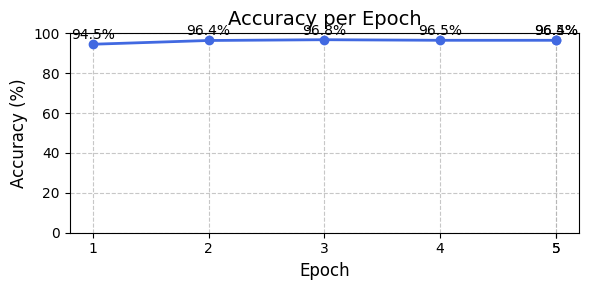

In [ ]:
log_history = trainer_sentiment.state.log_history
epochs = []
accuracies = []

for log in log_history:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accuracies.append(log['eval_accuracy'] * 100)

plt.figure(figsize=(6, 3))
plt.plot(epochs, accuracies, color='royalblue', linestyle='-', marker='o', linewidth=2, markersize=6)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Accuracy per Epoch", fontsize=14)
plt.xticks(epochs)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)

for x, y in zip(epochs, accuracies):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
trainer_sentiment.save_model("indobert_sentiment")

### Emotion Model

In [ ]:
model_emotion = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=5)
training_args_emotion = TrainingArguments(
    output_dir="./emotion_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_emotion = Trainer(
    model=model_emotion,
    args=training_args_emotion,
    train_dataset=train_dataset.rename_column("Emotion", "labels"),
    eval_dataset=test_dataset.rename_column("Emotion", "labels"),
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer_emotion.train()
trainer_emotion.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.902949,0.594340,0.642673,0.594340,0.597518
2,0.998600,0.819632,0.650943,0.645779,0.650943,0.625756
3,0.998600,0.793097,0.674528,0.669244,0.674528,0.669775
4,0.610600,0.861570,0.672642,0.671755,0.672642,0.663388
5,0.610600,0.882840,0.659434,0.655735,0.659434,0.654267


{'eval_loss': 0.7930966019630432,
 'eval_accuracy': 0.6745283018867925,
 'eval_precision': 0.6692444935279528,
 'eval_recall': 0.6745283018867925,
 'eval_f1': 0.6697747475626401,
 'eval_runtime': 3.5849,
 'eval_samples_per_second': 295.685,
 'eval_steps_per_second': 18.69,
 'epoch': 5.0}

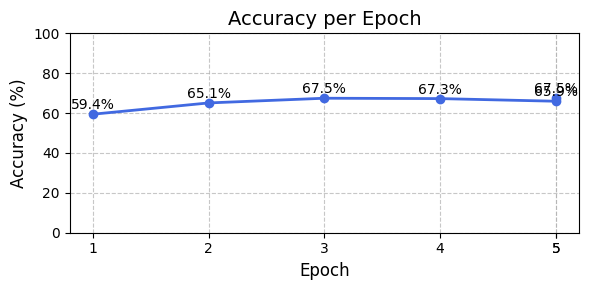

In [ ]:
log_history = trainer_emotion.state.log_history
epochs = []
accuracies = []

for log in log_history:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accuracies.append(log['eval_accuracy'] * 100)

plt.figure(figsize=(6, 3))
plt.plot(epochs, accuracies, color='royalblue', linestyle='-', marker='o', linewidth=2, markersize=6)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Accuracy per Epoch", fontsize=14)
plt.xticks(epochs)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)

for x, y in zip(epochs, accuracies):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


time:

In [ ]:
trainer_emotion.save_model("indobert_emotion")

# Save to gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r indobert_emotion /content/drive/MyDrive/
!cp -r indobert_sentiment /content/drive/MyDrive/